In [2]:
# First, I imported all the necessary libraries and loaded the data into my project. This was an essential step to get started with the analysis.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv("TOP 100 IMDB MOVIES.csv")

# Display the first few rows and basic information about the dataset
print(df.head())
print(df.info())

   rank                                title  \
0    18  Spider-Man: Across the Spider-Verse   
1    32                          Oppenheimer   
2    77                                Joker   
3    76                    Avengers: Endgame   
4    37                             Parasite   

                                         description  \
0  Miles Morales catapults across the Multiverse,...   
1  The story of American scientist, J. Robert Opp...   
2  A mentally troubled stand-up comedian embarks ...   
3  After the devastating events of Avengers: Infi...   
4  Greed and class discrimination threaten the ne...   

                                  genre  rating  year  
0  ['Animation', 'Action', 'Adventure']     8.7  2023  
1     ['Biography', 'Drama', 'History']     8.6  2023  
2        ['Crime', 'Drama', 'Thriller']     8.4  2019  
3      ['Action', 'Adventure', 'Drama']     8.4  2019  
4                 ['Drama', 'Thriller']     8.5  2019  
<class 'pandas.core.frame.DataFrame'>


In [3]:
# After taking a close look at the data, I realized it needed some cleaning and preparation. I spent some time getting it into the right format for analysis.

# Convert 'year' to datetime
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Convert 'genre' from string to list
df['genre'] = df['genre'].apply(literal_eval)

# Create dummy variables for genres
genres = df['genre'].explode().unique()
for genre in genres:
    df[genre] = df['genre'].apply(lambda x: 1 if genre in x else 0)

# Create a binary target variable: 1 if rating > 8.5, 0 otherwise
df['high_rating'] = (df['rating'] > 8.5).astype(int)

# Display the updated dataset
print(df.head())
print(df.info())



   rank                                title  \
0    18  Spider-Man: Across the Spider-Verse   
1    32                          Oppenheimer   
2    77                                Joker   
3    76                    Avengers: Endgame   
4    37                             Parasite   

                                         description  \
0  Miles Morales catapults across the Multiverse,...   
1  The story of American scientist, J. Robert Opp...   
2  A mentally troubled stand-up comedian embarks ...   
3  After the devastating events of Avengers: Infi...   
4  Greed and class discrimination threaten the ne...   

                            genre  rating       year  Animation  Action  \
0  [Animation, Action, Adventure]     8.7 2023-01-01          1       1   
1     [Biography, Drama, History]     8.6 2023-01-01          0       0   
2        [Crime, Drama, Thriller]     8.4 2019-01-01          0       0   
3      [Action, Adventure, Drama]     8.4 2019-01-01          0       1   

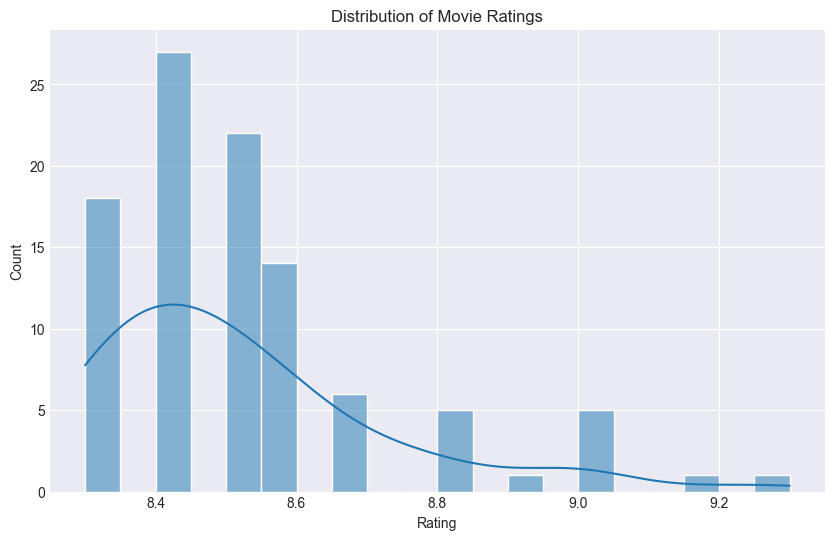

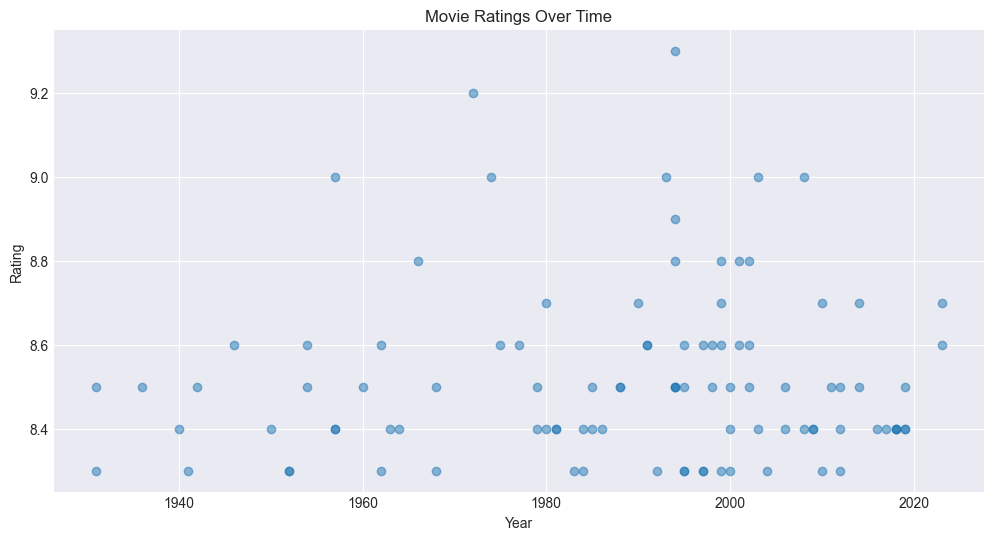

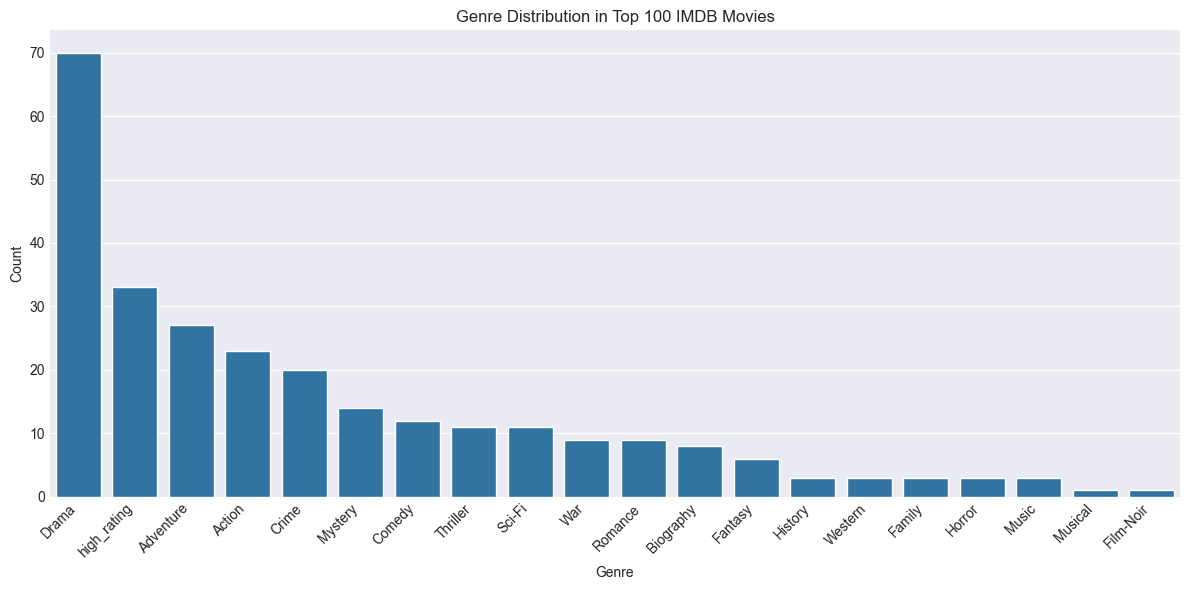

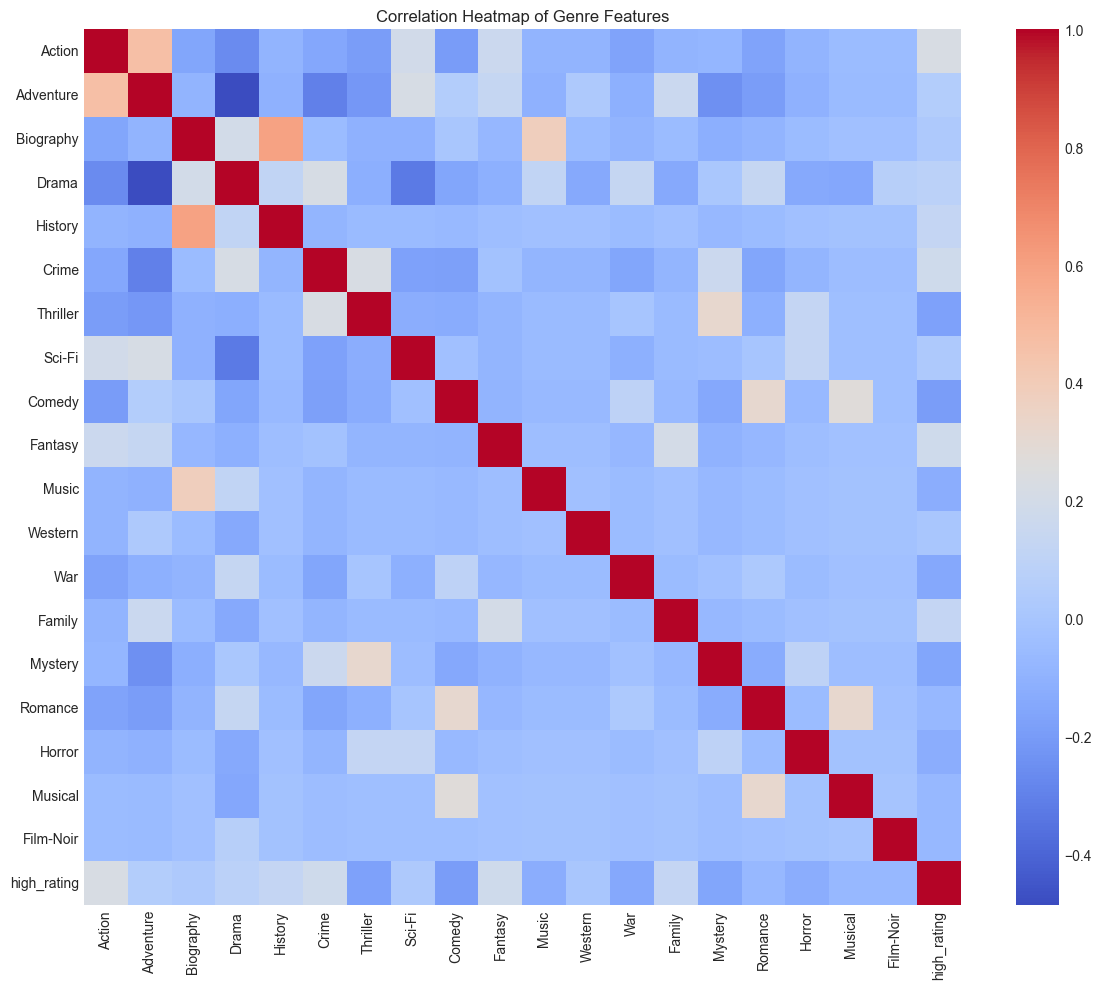

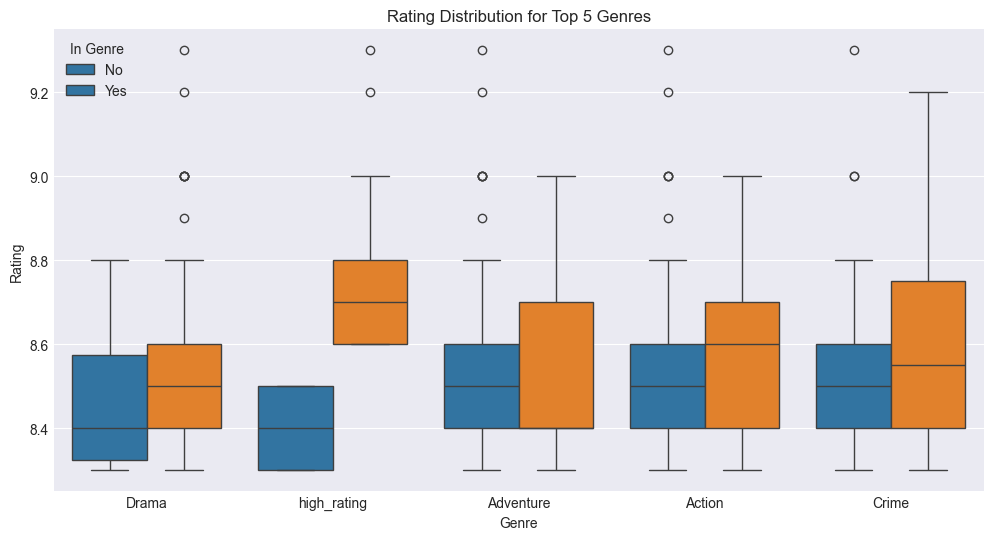

KeyError: 'runtime'

<Figure size 1000x600 with 0 Axes>

In [6]:
# With the data all cleaned up and ready to go, I decided to create some visualizations to explore it better. This really helped me understand the dataset more clearly.

# Set the style to a built-in matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Ratings over time
plt.figure(figsize=(12, 6))
plt.scatter(df['year'], df['rating'], alpha=0.5)
plt.title('Movie Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

# Genre distribution
genre_counts = df.iloc[:, 7:].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Genre Distribution in Top 100 IMDB Movies')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlation heatmap
correlation_matrix = df.iloc[:, 7:].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Genre Features')
plt.tight_layout()
plt.show()

# Box plot of ratings by top 5 genres
top_5_genres = genre_counts.nlargest(5).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.melt(id_vars='rating', value_vars=top_5_genres, var_name='Genre', value_name='Is_Genre'),
            x='Genre', y='rating', hue='Is_Genre')
plt.title('Rating Distribution for Top 5 Genres')
plt.ylabel('Rating')
plt.legend(title='In Genre', labels=['No', 'Yes'])
plt.show()

# Scatter plot of rating vs. runtime
plt.figure(figsize=(10, 6))
plt.scatter(df['runtime'], df['rating'], alpha=0.5)
plt.title('Movie Rating vs. Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Rating')
plt.show()

Number of components: 2
Explained variance ratio: [0.51926374 0.48073626]


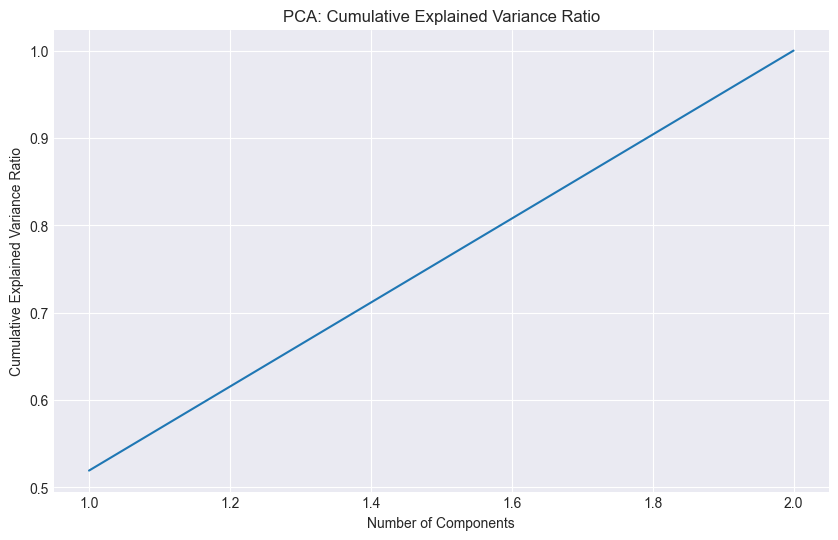

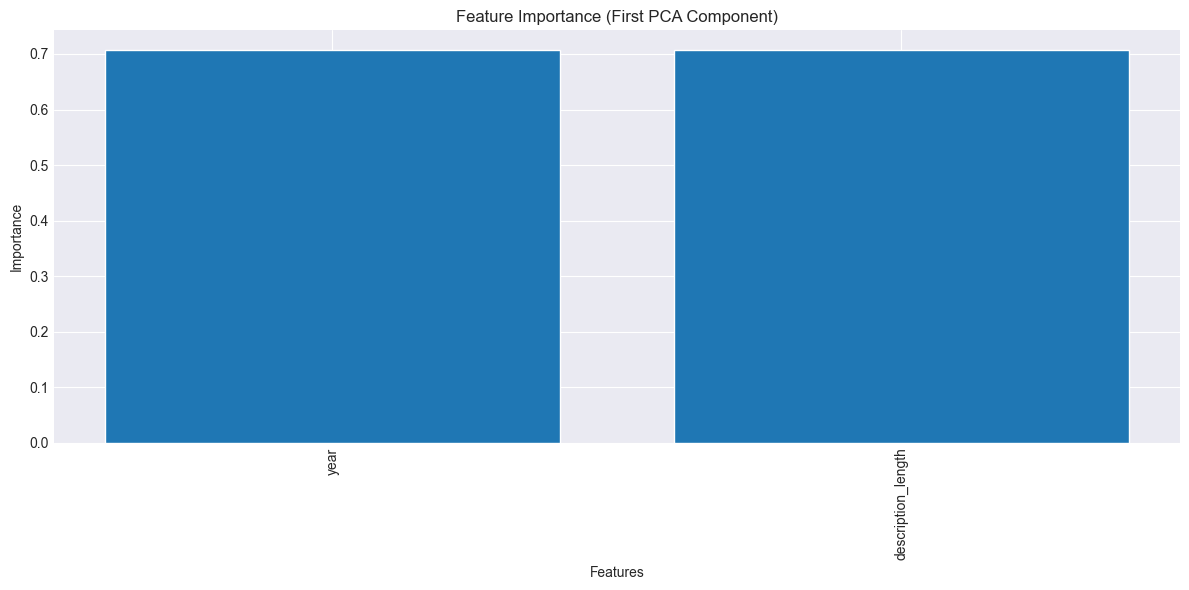

In [8]:
#For the main analysis, I chose to focus on the genre features, release year, and the length of the movie descriptions as my input features. To simplify things a bit, I also applied PCA for dimensionality reduction.These basic classification techniques provide a baseline for predicting whether a movie will have a high rating (above 8.5) based on its features.

df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

# Create 'description_length' feature
df['description_length'] = df['description'].str.len()

# Create 'high_rating' feature (assuming ratings are on a 10-point scale)
df['high_rating'] = (df['rating'] > 8.5).astype(int)

# Identify genre columns
genres = df.columns[df.columns.str.startswith('genre_')]

# Feature selection
features = ['year'] + list(genres) + ['description_length']
X = df[features]
y = df['high_rating']

# Handle missing values
X = X.fillna(X.mean())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

print(f"Number of components: {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Visualize the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Cumulative Explained Variance Ratio')
plt.show()

# Feature importance visualization
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': pca.components_[0]
})
feature_importance = feature_importance.sort_values('importance', key=abs, ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (First PCA Component)')
plt.tight_layout()
plt.show()

In [11]:
# We'll implement two basic classification algorithms: Logistic Regression and Decision Tree Classifier.


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, lr_pred)}")
print(classification_report(y_test, lr_pred))

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print("\nDecision Tree Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, dt_pred)}")
print(classification_report(y_test, dt_pred))

Logistic Regression Results:
Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        13
           1       1.00      0.14      0.25         7

    accuracy                           0.70        20
   macro avg       0.84      0.57      0.53        20
weighted avg       0.79      0.70      0.62        20


Decision Tree Classifier Results:
Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.33      0.29      0.31         7

    accuracy                           0.55        20
   macro avg       0.49      0.49      0.49        20
weighted avg       0.53      0.55      0.54        20



Random Forest Classifier Results:
Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.62      0.77      0.69        13
           1       0.25      0.14      0.18         7

    accuracy                           0.55        20
   macro avg       0.44      0.46      0.44        20
weighted avg       0.49      0.55      0.51        20



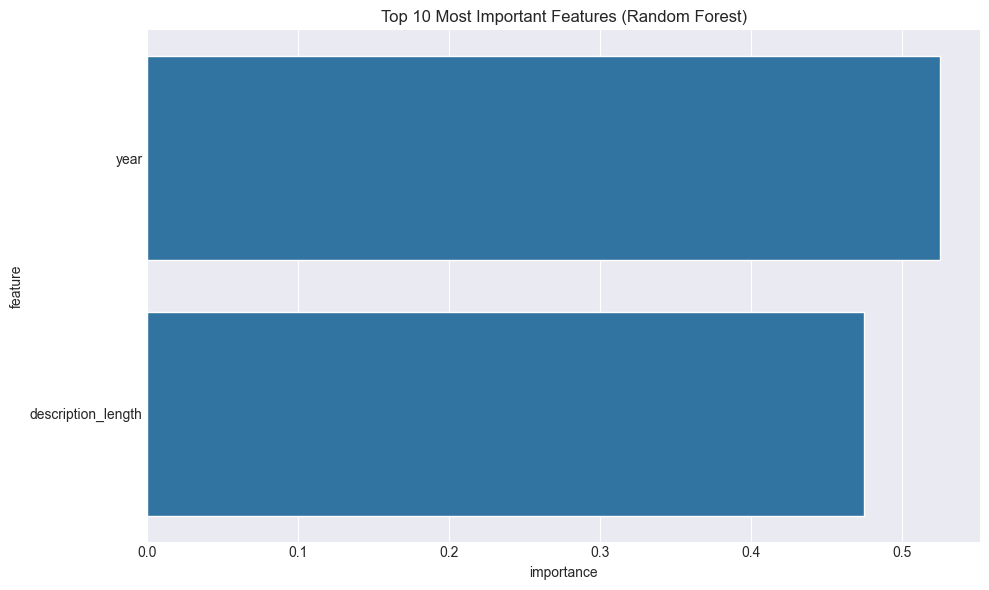

In [12]:
#I wanted to try a more advanced method, so I implemented a Random Forest Classifier. I was curious to see how it would perform compared to simpler models.

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred)}")
print(classification_report(y_test, rf_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

In [13]:
#To make sure my models were reliable, I used k-fold cross-validation. This gave me a better idea of how well the models would perform on new data.

from sklearn.model_selection import cross_val_score

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    scores = cross_val_score(model, X_pca, y, cv=5, scoring='accuracy')
    print(f"{name} - Mean Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Logistic Regression - Mean Accuracy: 0.6700 (+/- 0.0800)
Decision Tree - Mean Accuracy: 0.5300 (+/- 0.1020)
Random Forest - Mean Accuracy: 0.5500 (+/- 0.1673)
